### Previsão de preços
#### Período de análise: Janeiro de 2010 até Março de 2021.
##### Autor: Saulo Brendo Alves de Jesus 
##### LinkedIn: linkedin.com/in/saulo-brendo/

### Bibliotecas

In [1]:
# Bibliotecas utilizadas
import pandas as pd
from pandas_datareader import data
import numpy as np
import seaborn as sns
import statsmodels.tsa.stattools as ts 
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

### Importação de dados

In [2]:
# Definir ativo
ticker = "^GSPC"

# Definindo período
init_data = '1/1/2010'
end_data = "31/03/2021"

# Solicitação de dados através da API
dados_ativo = data.DataReader(ticker,'yahoo',init_data,end_data)

# Remover coluna Close
del dados_ativo["Close"]

dados_ativo.head()

,High,Low,Open,Volume,Adj Close
Date,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,5270680000,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,4389590000,1144.979980


### Tratamento

In [3]:
# Transformar dados diários em semanais
dados_ativo = dados_ativo.asfreq('W-FRI', method='pad')
dados_ativo.head()

,High,Low,Open,Volume,Adj Close
Date,,,,,
2010-01-08,1145.390015,1136.219971,1140.520020,4389590000,1144.979980
2010-01-15,1147.770020,1131.390015,1147.719971,4758730000,1136.030029
2010-01-22,1115.489990,1090.180054,1115.489990,6208650000,1091.760010
2010-01-29,1096.449951,1071.589966,1087.609985,5412850000,1073.869995
2010-02-05,1067.130005,1044.500000,1064.119995,6438900000,1066.189941


In [4]:
# Copiar coluna data 
dados_ativo["Date"] = dados_ativo.index
dados_ativo.head()

,High,Low,Open,Volume,Adj Close,Date
Date,,,,,,
2010-01-08,1145.390015,1136.219971,1140.520020,4389590000,1144.979980,2010-01-08
2010-01-15,1147.770020,1131.390015,1147.719971,4758730000,1136.030029,2010-01-15
2010-01-22,1115.489990,1090.180054,1115.489990,6208650000,1091.760010,2010-01-22
2010-01-29,1096.449951,1071.589966,1087.609985,5412850000,1073.869995,2010-01-29
2010-02-05,1067.130005,1044.500000,1064.119995,6438900000,1066.189941,2010-02-05


In [5]:
# Verificar informações sobre os ativos
dados_ativo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 586 entries, 2010-01-08 to 2021-03-26
Freq: W-FRI
Data columns (total 6 columns):
High         586 non-null float64
Low          586 non-null float64
Open         586 non-null float64
Volume       586 non-null int64
Adj Close    586 non-null float64
Date         586 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 32.0 KB


In [6]:
# Definir valor das Médias Móveis rápida e lenta
FastMA = 5
SlowMA = 15

# Criar coluna com os valores das Médias Móveis
dados_ativo['Fast MA'] = np.round(dados_ativo['Adj Close'].rolling(window=FastMA).mean(),2)
dados_ativo['Slow MA'] = np.round(dados_ativo['Adj Close'].rolling(window=SlowMA).mean(),2)

# Shifitar dados
dados_ativo['Adj Close'] = dados_ativo['Adj Close'].shift(-1)
dados_ativo.tail()

# Remover NA's
dados_ativo = dados_ativo.dropna()

dados_ativo.tail()

,High,Low,Open,Volume,Adj Close,Date,Fast MA,Slow MA
Date,,,,,,,,
2021-02-19,3930.409912,3903.070068,3921.159912,4823940000,3811.149902,2021-02-19,3856.82,3745.94
2021-02-26,3861.080078,3789.540039,3839.659912,6512950000,3841.939941,2021-02-26,3850.75,3761.01
2021-03-05,3851.689941,3730.189941,3793.580078,6842570000,3943.340088,2021-03-05,3876.29,3779.97
2021-03-12,3944.989990,3915.209961,3924.520020,4469240000,3913.100098,2021-03-12,3887.59,3800.30
2021-03-19,3930.120117,3886.750000,3913.139893,7725050000,3974.540039,2021-03-19,3883.25,3814.57


In [7]:
# Separar dados
linhas_total = len(dados_ativo)
linhas_treino = linhas_total - 300
linhas_teste = linhas_total - 15
linhas_valid = linhas_treino - linhas_teste

info = (
    f"Treino = 0:{linhas_treino}"
    f" Teste = {linhas_treino}:{linhas_teste}"
    f" Validação = {linhas_teste}:{linhas_total}"
)

info

'Treino = 0:271 Teste = 271:556 Validação = 556:571'

In [8]:
# Alterar Índice
dados_ativo = dados_ativo.reset_index(drop = True)
dados_ativo.head()

,High,Low,Open,Volume,Adj Close,Date,Fast MA,Slow MA
0,1210.170044,1186.770020,1210.170044,8108470000,1217.280029,2010-04-16,1178.22,1132.12
1,1217.280029,1205.099976,1207.869995,5326060000,1186.689941,2010-04-23,1189.69,1136.94
2,1207.989990,1186.319946,1206.770020,6048260000,1110.880005,2010-04-30,1193.71,1140.32
3,1135.130005,1094.150024,1127.040039,9472910000,1135.680054,2010-05-07,1180.27,1141.59
4,1157.189941,1126.140015,1157.189941,6126400000,1087.689941,2010-05-14,1168.53,1145.71


### Modelagem

In [9]:
# Features e Labels
features = dados_ativo.drop(["Adj Close", "Date"], 1)
labels = dados_ativo["Adj Close"]

In [10]:
# Seleção das melhores Features utilizando Kbest
features_list = ("High", "Low", "Open","Volume", "Fast MA", "Slow MA")

# Kbest Model
kbest_features = SelectKBest(k = 'all')
kbest_features.fit_transform(features, labels)
kbest_features_scores = kbest_features.scores_

# União e Ordenação
raw_pairs = zip(features_list[1:], kbest_features_scores)
order_pairs = list(reversed(sorted(raw_pairs, key = lambda x: x[1])))

kbest_features_final = dict(order_pairs[:15])
best_features = kbest_features_final.keys()
print("")
print("Best Features: ")
print(kbest_features_final)


Best Features: 
{'Open': 4116.3678918807955, 'Low': 1378.823576686178, 'Volume': 972.3406615534943, 'Slow MA': 282.2966490539432, 'Fast MA': 0.8914603774067733}


In [11]:
# Remoção de Features indesejadas
features = dados_ativo.drop(["Adj Close", "Date", "Fast MA"], 1)

In [12]:
# Normalização de entradas

# Geração de novo padrão
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print("Features: ", features_scale.shape)
print(features_scale)

Features:  (571, 5)
[[0.06085771 0.05892498 0.06300594 0.83581932 0.01823033]
 [0.06329929 0.06524723 0.06221196 0.50101677 0.01999444]
 [0.06010908 0.05876975 0.06183225 0.58791784 0.02123151]
 ...
 [0.96796059 0.93618415 0.95479951 0.68349578 0.98733649]
 [1.         1.         1.         0.39791712 0.99477722]
 [0.99489366 0.99018378 0.99607158 0.78968306 1.        ]]


/home/lbs/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
# Separar dados de treino, teste e validação
x_treino = features_scale[:linhas_treino]
x_teste = features_scale[linhas_treino:linhas_teste]

y_treino = labels[:linhas_treino]
y_teste = labels[linhas_treino:linhas_teste]

print(len(x_treino), len(y_treino))
print(len(x_teste), len(y_teste))

271 271
285 285


In [14]:
# Regressão Linear
lr = linear_model.LinearRegression()
lr.fit(x_treino, y_treino)
predict = lr.predict(x_teste)
cd = r2_score(y_teste, predict)

f"Coeficiente de Determinação:{cd * 100:.2f}"

'Coeficiente de Determinação:97.63'

### Previsão

In [15]:
# Previsão com Regressão Linear

prevision = features_scale[linhas_teste:linhas_total]

data_total = dados_ativo["Date"]
data = data_total[linhas_teste:linhas_total]

price_real = dados_ativo["Adj Close"]
price = price_real[linhas_teste:linhas_total]

predict = lr.predict(prevision)

# DataFrame com valores de preço real e preço predito
df = pd.DataFrame({'Data':data,
                   'Real Price':price, 'Pred Price':predict})

df.set_index('Data', inplace = True)

df.head()

,Real Price,Pred Price
Data,,
2020-12-11,3709.409912,3636.583227
2020-12-18,3703.060059,3676.668866
2020-12-25,3756.070068,3692.265589
2021-01-01,3824.679932,3743.805676
2021-01-08,3768.250000,3787.280991


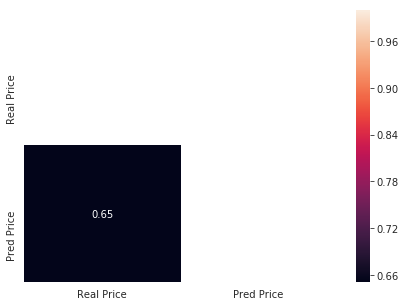

In [16]:
# Correlação
corr = df.corr()

# Criar mascara para visualizar apenas uma das partes
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plotar gráfico de correlação
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, annot=True)

/home/lbs/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


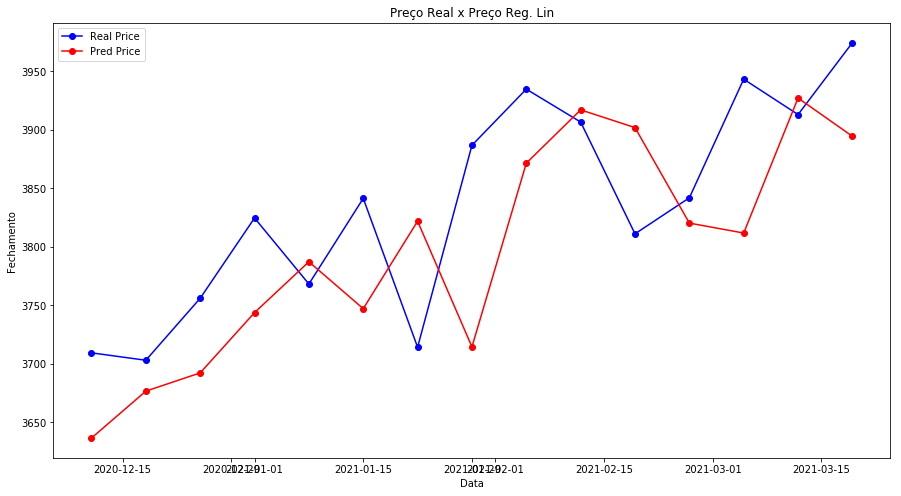

In [17]:
# Plot Gráfico
plt.figure(figsize = (15,8))
plt.title("Preço Real x Preço Reg. Lin")
plt.plot(df['Real Price'], label = 'Real Price',
         color = 'blue', marker = 'o')
plt.plot(df['Pred Price'], label = 'Pred Price', 
        color = 'red', marker = 'o')
plt.xlabel('Data')
plt.ylabel('Fechamento')
leg = plt.legend()